In [2]:
from multiprocessing import Pool
from sage.all import matrix  # testing
from sage.all import *
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from flatsurf import *
import os
import pwlf
from surface_dynamics.all import *
import math
from time import time
import copy
from scipy import integrate
import traceback
import dill
import sys
import unittest
from surface_dynamics.all import Origami
from utils import load_arrays_from_file  # testing
from fractions import Fraction as frac
import sympy as sym
from sympy import Symbol
from sympy import solve, lambdify, Eq
from sympy import Rational, sqrt
from Library import *
from Library import Section

In [3]:
# number of squares for STS
n_squares = 7
# index to start at
index = 0
dx = 0.0005

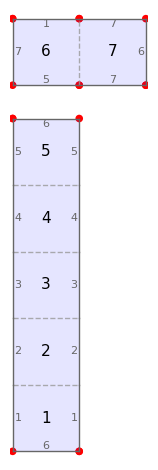

In [4]:
permutations = perms_list(n_squares)
perm = permutations[index]
perm.show()

In [5]:
vec_file = "vecs" + str(n_squares) + "-" + str(index) + ".npy"
vecs0 = load_arrays_from_file(os.path.join("vecs", vec_file))

FileNotFoundError: [Errno 2] No such file or directory: 'vecs/vecs7-0.npy'

In [ ]:
# generate a list of alpha, c matrices, and eigenvectors for each cusp of the STS to experiment with to find "nice" sections for our poincare sections

with open(os.path.join("results", f"{n_squares} - {index}", "setup.dill"), 'rb') as f:
    a,c,e,gs = dill.load(f)

a = []
c = []
e = []
g = []
for num in range(10):
    try:
        alphas, Cs, Ss, eigs, Ms, gens, eigenvecs = poincare_setup(perm, vecs0, g)
        print(alphas)
    except Exception as ex:
        print(ex)
        continue
    a.append(alphas)
    c.append(Cs)
    e.append(eigenvecs)
    g.append(generators)
print(f'length of alphas: {len(a)}')

In [6]:
with open(os.path.join("results", f"{n_squares} - {index}", "setup.dill"), 'rb') as f:
    a,c,e,gs = dill.load(f)

if a == a:
    print("a passed")
else:
    print("a FAILED")
if c == c:
    print("c passed")
else:
    print("c FAILED")
if e == e:
    print("e passed")
else:
    print("e FAILED")

In [ ]:
# list to check all output
all_output = []

# can change j to look at only one cusp
for j in range(len(a[0]])):
    
    # list to collect output at each cusp
    cusp_output = []
    
    list_as = []
    list_cs = []
    list_es = []
    for a_, c_, e_ in zip(a, c, e):
        list_as.append(a_[j])
        list_cs.append(c_[j])
        list_es.append(e_[j])
    
    # Sort a, c, and e together based on the absolute value of the lower-right entry of c
    sorted_pairs = sorted(zip(list_as, list_cs, list_es), key=lambda pair: abs(pair[1][1, 1]) + abs(pair[1][1,0]))
    
    # Unzip back into separate sorted lists
    sorted_a, sorted_c, sorted_e = zip(*sorted_pairs)
    
    # Convert tuples to lists
    sorted_a = list(sorted_a)
    sorted_c = list(sorted_c)
    sorted_e = list(sorted_e)
    
    for i in range(len(sorted_a)):
        # get dimensions of section
        vecs, x_vals, m0, m1, x0, y0, dx_y, z = setup(
            sorted_a[i], sorted_c[i], sorted_e[i], vecs0, dx, True)
        
        print("i = " + str(i), "j = " + str(j))
    
        if float(z) <= float(1/50000):
            print("too small")
            continue
    
        # create a dataframe with winning vector at certain points in the section
        df = winners(vecs, x_vals, m0, m1, y0, dx, dx_y)
        cusp_output.append(df)
        # plot poincare section and save
        try:
            plot(df, vecs, sorted_c[i], j, n_squares, index, test=False)
        except Exception as error:
            print(error)
            continue
    
        # make section object that define winning vector and line equations for boundaries of subsections
        sec_list = sec_setup(df, dx_y)
        secs = sec_comp(sec_list, dx)
        sec_list2, vec_order, vec_dict = sec_setup2(df, dx_y)
        secs2 = sec_comp2(df, sec_list2, vec_order, vec_dict, dx, dx_y, m1, y0)

        cusp_output.extend([secs, secs2])
    
        times = time_comp(secs)
    
        # plot the pdf for each cusp
        pdf(list(df["time"]), times, dx*2, n_squares, index, j)
        
        print(f"section {j} done")

        all_output.append(cusp_output)
        
        break

In [ ]:
for i, results in enumerate(all_output):
    df = results[0]
    secs = results[1]
    secs2 = results[2]

    df0 = pd.read_csv(os.path.join("results", f"{n_squares} - {index}", f"df - {i}.csv"))
    
    with open(os.path.join("results", f"{n_squares} - {index}", f"secs - {i}.dill"), 'rb') as f:
        secs0 = dill.load(f)

    with open(os.path.join("results", f"{n_squares} - {index}", f"secs_integrals - {i}.dill"), 'rb') as f:
        secs2_0 = dill.load(f)

    print(f"cusp: {i}")
    if df == df0:
        print("df passed")
    else:
        print("df FAILED")
    if secs == secs0:
        print("secs passed")
    else:
        print("secs FAILED")
    if secs2 == secs2_0:
        print("secs2 passed")
    else:
        print("secs2 FAILED")